<a href="https://colab.research.google.com/github/azrizalg/azrizalg/blob/main/Prediksi_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparasi Data 1

### Impor library

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from datetime import timedelta
from google.colab import files
from google.colab import drive
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
import sys, os
import warnings
warnings.simplefilter(action='ignore')

In [ ]:
# Jalankan kode ini untuk install library
!pip install pmdarima

In [ ]:
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Authorization

In [ ]:
drive.mount('/content/gdrive')
from google.colab import auth
auth.authenticate_user()# verify your account to read files which you have access to. Make sure you have permission to read the file!
import gspread
from oauth2client.client import GoogleCredentials as GC
gc = gspread.authorize(GC.get_application_default())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Impor data

In [ ]:
url_case = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovery = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
df_dataLokasi = pd.read_csv('https://drive.google.com/uc?export=download&id=1oSPiGpmAW08DnYPk0xg03fDwdKZduZOF')
df_case = pd.read_csv(url_case)
df_death = pd.read_csv(url_death)
df_recovery = pd.read_csv(url_recovery)

### merubah bentuk dan format dataframe

In [ ]:
df_case = df_case.drop(['Province/State', 'Lat','Long'], axis=1)
df_case = df_case.groupby(['Country/Region']).sum() #karena terdapat region yang double
df_case = df_case.transpose().reset_index()
df_case = pd.melt(df_case,id_vars=['index'])
df_case.rename(columns={'value': 'total_cases'}, inplace=True)

df_death = df_death.drop(['Province/State', 'Lat','Long'], axis=1)
df_death = df_death.groupby(['Country/Region']).sum()
df_death = df_death.transpose().reset_index()
df_death = pd.melt(df_death,id_vars=['index'])
df_death.rename(columns={'value': 'total_deaths'}, inplace=True)#inplace = dataframe di replace langsung

df_recovery = df_recovery.drop(['Province/State', 'Lat','Long'], axis=1)
df_recovery = df_recovery.groupby(['Country/Region']).sum()
df_recovery = df_recovery.transpose().reset_index()
df_recovery = pd.melt(df_recovery,id_vars=['index'])
df_recovery.rename(columns={'value': 'total_recoveries'}, inplace=True)

#merge ketiga dataframe diatas menjadi satu
dataset = pd.merge(df_case, df_death, on=['index','Country/Region'])
dataset = pd.merge(dataset, df_recovery, on=['index','Country/Region'])
dataset.rename(columns={'index': 'tanggal'}, inplace=True)
dataset['tanggal'] = pd.to_datetime(dataset['tanggal'])#ubah format kolom tanggal dari obj ke datetime
df = dataset.groupby(['tanggal']).sum().reset_index()# digabung berdasarkan tanggalnya

### Menambahkan data harian (bukan total)

In [ ]:
#kasus
df['new_cases'] = df['total_cases'] - df['total_cases'].shift(+1, fill_value=0)#memasukkan selisih kasus dengan hari sebelumnya
#df['new_cases'][df['new_cases'] < 0] = 0 #menghilangkan nilai negatif yang dihasilkan dari kode diatas

#kematian
df['new_deaths'] = df['total_deaths'] - df['total_deaths'].shift(+1, fill_value=0)
#df['new_deaths'][df['new_deaths'] < 0] = 0 #menghilangkan nilai negatif yang dihasilkan dari kode diatas

#recovery
df['new_recoveries'] = df['total_recoveries'] - df['total_recoveries'].shift(+1, fill_value=0)

#remove value negative
c = ['new_cases','new_deaths','new_recoveries']
df[c] = df[c].clip(lower=0)

### Merubah index tanggal

In [ ]:
df_analisa = df.copy()
df_analisa['tanggal'] = pd.to_datetime(df_analisa['tanggal'])
df_analisa.set_index(['tanggal'], inplace=True)
df_analisa = df_analisa.asfreq(freq='D')
df_analisa

,total_cases,total_deaths,total_recoveries,new_cases,new_deaths,new_recoveries
tanggal,,,,,,
2020-01-22,557,17,30,557,17,30
2020-01-23,655,18,32,98,1,2
2020-01-24,941,26,39,286,8,7
2020-01-25,1433,42,42,492,16,3
2020-01-26,2118,56,56,685,14,14
...,...,...,...,...,...,...
2021-04-10,135355887,2927897,76891123,664507,12407,382234
2021-04-11,136046628,2936454,77419350,690741,8557,528227
2021-04-12,136663253,2945752,77811309,616625,9298,391959


# Data understanding

### korelasi

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(7)

,total_cases,total_deaths,total_recoveries,new_cases,new_deaths,new_recoveries
total_cases,1.0000000,0.9927441,0.9965747,0.7994851,0.7571815,0.7288481
total_deaths,0.9927441,1.0000000,0.9933026,0.8129916,0.7656724,0.7553061
total_recoveries,0.9965747,0.9933026,1.0000000,0.8229254,0.7568990,0.7595088
new_cases,0.7994851,0.8129916,0.8229254,1.0000000,0.8567748,0.8590798
new_deaths,0.7571815,0.7656724,0.7568990,0.8567748,1.0000000,0.7446987
new_recoveries,0.7288481,0.7553061,0.7595088,0.8590798,0.7446987,1.0000000


### cek nilai null

In [ ]:
print(df.isnull().any())

tanggal             False
total_cases         False
total_deaths        False
total_recoveries    False
new_cases           False
new_deaths          False
new_recoveries      False
dtype: bool


### cek tanggal yang hilang

In [ ]:
start = df_analisa.index[0]
end = df_analisa.index[-1]
ll = pd.date_range(start, end).tolist()
missing = [(i,j) for i,j in enumerate(ll) if j not in df_analisa.index]
print(missing)

[]


### Membuat plot dari data

AxesSubplot(0.125,0.125;0.775x0.755)


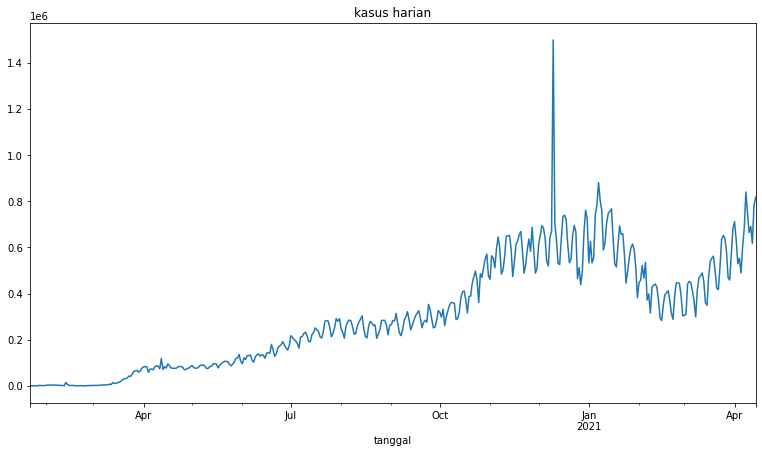

In [ ]:
print(df_analisa['new_cases'].plot(title='kasus harian', kind='line', figsize=(13,7)))

AxesSubplot(0.125,0.125;0.775x0.755)


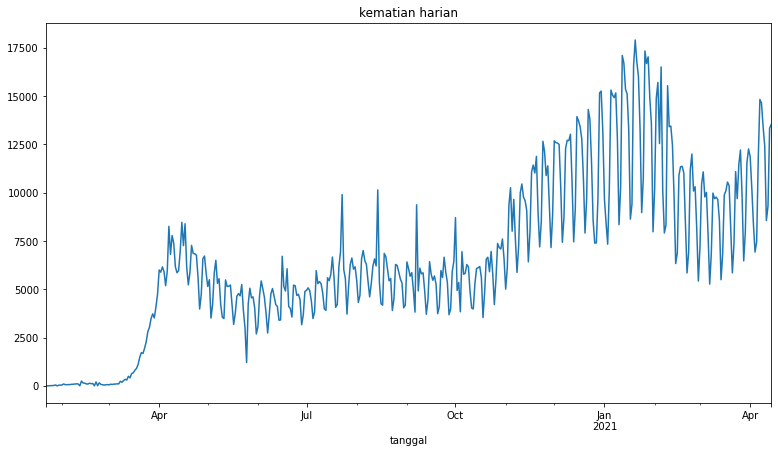

In [ ]:
print(df_analisa['new_deaths'].plot(title='kematian harian', kind='line', figsize=(13,7)))

AxesSubplot(0.125,0.125;0.775x0.755)


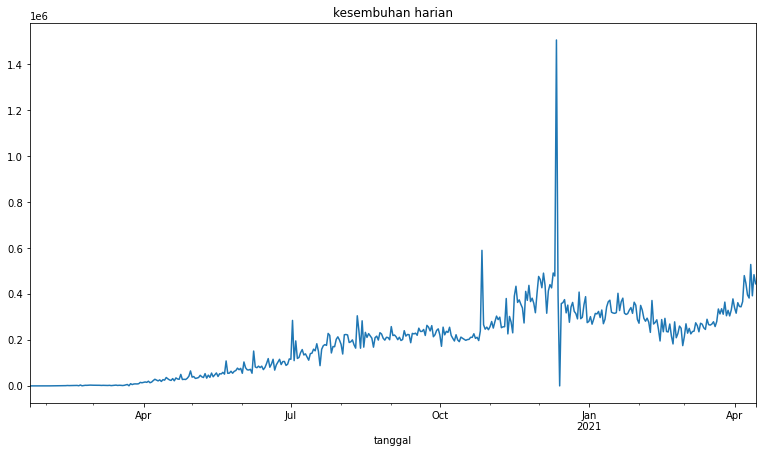

In [ ]:
print(df_analisa['new_recoveries'].plot(title='kesembuhan harian', kind='line', figsize=(13,7)))

### ETS Decomposition

In [ ]:
etsd_case = seasonal_decompose(df_analisa['new_cases'], model='multiplicative')

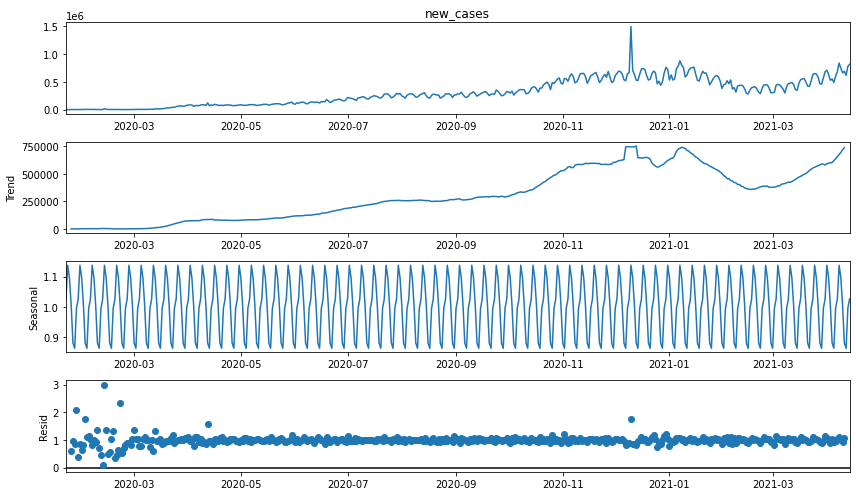

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,7

etsd_case.plot();

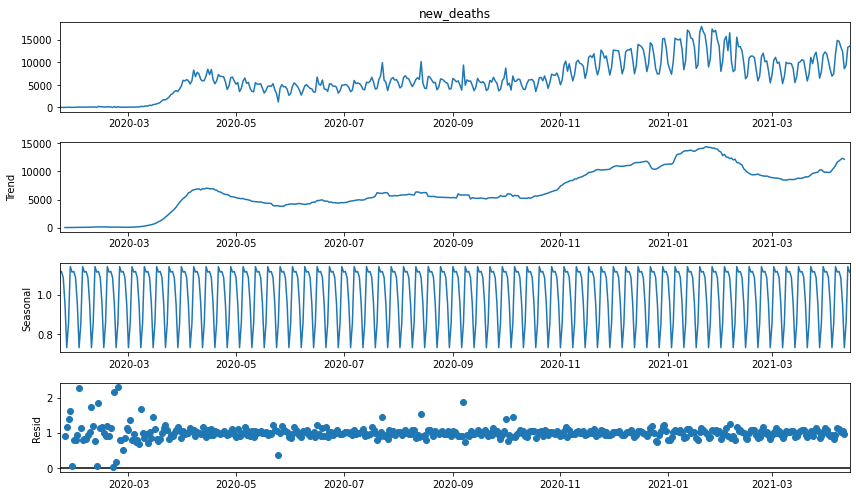

In [ ]:
etsd_death = seasonal_decompose(df_analisa['new_deaths'], model='multiplicative')
etsd_death.plot();

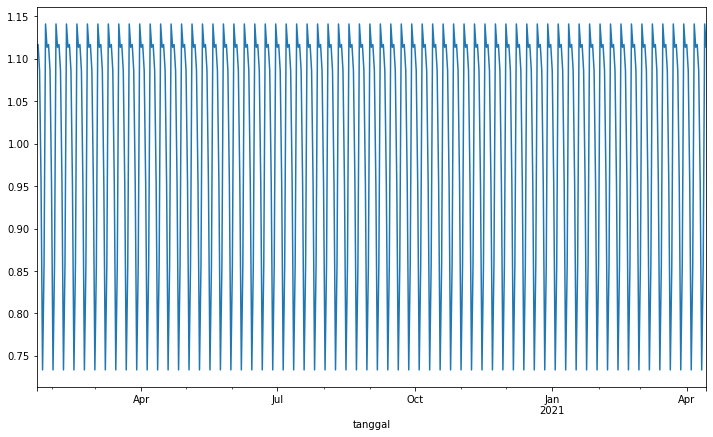

In [ ]:
etsd_death.seasonal.plot()

### Decomposition Alternative

In [ ]:
def decompose(df, col):
    stl = STL(df[col])
    result = stl.fit()
    fig, ax = plt.subplots(2, 2, figsize=(18,6))
    colors = sns.color_palette('deep')
    ax[0,0].plot(df[col], label='Original Series', color=colors[0])
    ax[0,0].plot(result.trend + result.seasonal, label='trend + seasonality', color='red')
    ax[0,0].legend()
    ax[0,1].plot(result.trend, color=colors[2]); ax[0,1].set_title('Trend')
    ax[1,0].plot(result.seasonal, color=colors[4]); ax[1,0].set_title('Seasonality')
    mu, std = np.mean(result.resid), np.std(result.resid)
    up, dw = mu + 3*std, mu - 3*std
    ax[1,1].plot(result.resid, color=colors[1]); ax[1,1].set_title('Residual')
    ax[1,1].fill_between(df_analisa.index, dw, up, color='g', alpha=0.1)
    for i in range(2): 
        for j in range(2): 
            ax[i,j].grid()
    plt.tight_layout()

In [ ]:
#from statsmodels.tsa.seasonal import STL
#decompose(df_analisa, 'new_cases')

## Stasioneritas data

### Kasus

In [ ]:
temp = adfuller(df_analisa['new_cases'], autolag='AIC')
adf_case = pd.Series(temp[:4], index=['ADF test statistics', 'p-value','# lags used', '# observations'])
for key, val in temp[4].items(): # ngambil dictionary dari df test
  adf_case[f'critical value ({key})'] = val

print(adf_case)

ADF test statistics      -0.435646
p-value                   0.903975
# lags used              10.000000
# observations          438.000000
critical value (1%)      -3.445368
critical value (5%)      -2.868161
critical value (10%)     -2.570297
dtype: float64


### Kematian

In [ ]:
temp = adfuller(df_analisa['new_deaths'], autolag='AIC')
adf_death = pd.Series(temp[:4], index=['ADF test statistics', 'p-value','# lags used', '# observations'])
for key, val in temp[4].items(): # ngambil dictionary dari df test
  adf_death[f'critical value ({key})'] = val

print(adf_death)

ADF test statistics      -1.849335
p-value                   0.356258
# lags used              18.000000
# observations          430.000000
critical value (1%)      -3.445649
critical value (5%)      -2.868285
critical value (10%)     -2.570363
dtype: float64


# Preparasi Data 2

### Pencilan

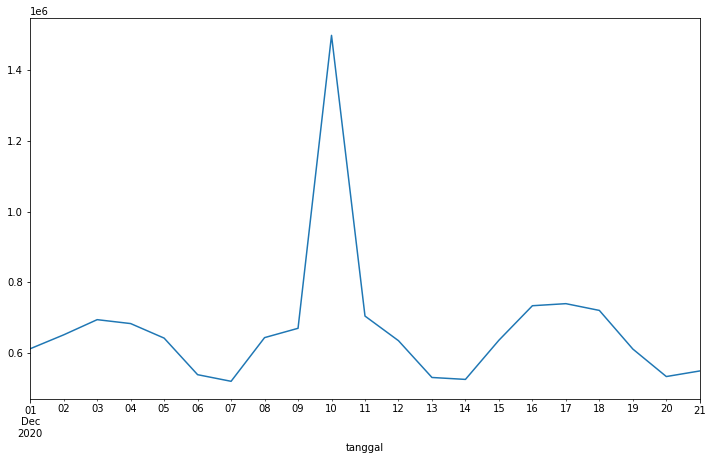

In [ ]:
df_analisa.loc['2020-12-1':'2020-12-21', 'new_cases'].plot()

In [ ]:
outlier = df_analisa.loc['2020-12-1':'2020-12-20', 'new_cases'].resample('W').max()
outlier

tanggal
2020-12-06     694328
2020-12-13    1498213
2020-12-20     739582
Freq: W-SUN, Name: new_cases, dtype: int64

In [ ]:
outlier_fill = (outlier.loc['2020-12-06'] + outlier.loc['2020-12-20'])/2
df_analisa.loc['2020-12-10','new_cases'] = outlier_fill

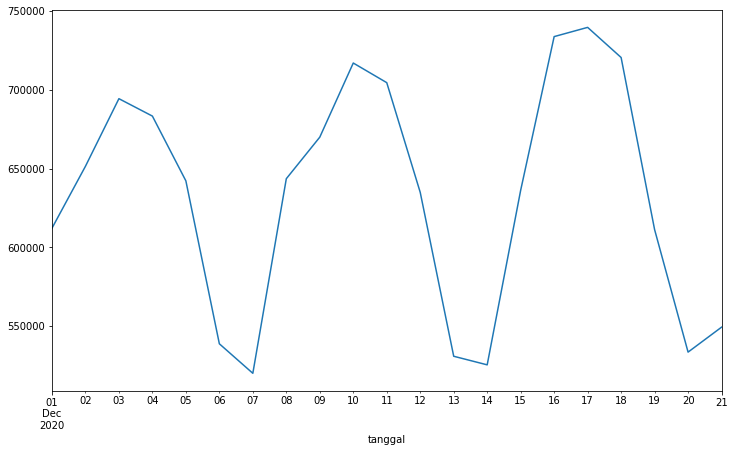

In [ ]:
df_analisa.loc['2020-12-1':'2020-12-21', 'new_cases'].plot()

### Split Data

In [ ]:
len(df_analisa)

449

In [ ]:
train = df_analisa.iloc[:300,:]
test = df_analisa.iloc[301:,:] 

### Grafik Dunia

In [ ]:
df_worldGraph = df.copy()
df_worldGraph

,tanggal,total_cases,total_deaths,total_recoveries,new_cases,new_deaths,new_recoveries
0,2020-01-22,557,17,30,557,17,30
1,2020-01-23,655,18,32,98,1,2
2,2020-01-24,941,26,39,286,8,7
3,2020-01-25,1433,42,42,492,16,3
4,2020-01-26,2118,56,56,685,14,14
...,...,...,...,...,...,...,...
444,2021-04-10,135355887,2927897,76891123,664507,12407,382234
445,2021-04-11,136046628,2936454,77419350,690741,8557,528227
446,2021-04-12,136663253,2945752,77811309,616625,9298,391959
447,2021-04-13,137442820,2959084,78295227,779567,13332,483918


## Grafik Dunia Regional

In [ ]:
df_regional = dataset.copy()
df_regional = pd.merge(df_dataLokasi, dataset, how='left', on='Country/Region')

## Grafik Indonesia

In [ ]:
#ambil yang memiliki nilai Indonesia pada kolom COuntry/Region
df_idGraph = dataset.loc[dataset['Country/Region'] == 'Indonesia']
df_idGraph

,tanggal,Country/Region,total_cases,total_deaths,total_recoveries
35920,2020-01-22,Indonesia,0,0,0
35921,2020-01-23,Indonesia,0,0,0
35922,2020-01-24,Indonesia,0,0,0
35923,2020-01-25,Indonesia,0,0,0
35924,2020-01-26,Indonesia,0,0,0
...,...,...,...,...,...
36364,2021-04-10,Indonesia,1562868,42443,1409288
36365,2021-04-11,Indonesia,1566995,42530,1414507
36366,2021-04-12,Indonesia,1571824,42656,1419796
36367,2021-04-13,Indonesia,1577526,42782,1426145


## Peta Covid

In [ ]:
df_map = dataset.copy()

#num = df_map['tanggal'].max()
df_map = df_map.loc[df_map['tanggal'] == df_map['tanggal'].max()]#ambil baris yang memiliki nilai kolom tanggal nya paling besar (hari paling terkini)
df_map= df_map.drop('tanggal', axis=1)

#Merge df_map dengan df_dataLokasi, untuk menambahkan ISO_CODE dan nama negara dengan bahasa Indonesia 
df_map = pd.merge(df_map, df_dataLokasi, on=['Country/Region'])
df_map.rename(columns={'alpha-3': 'iso_code'}, inplace=True)#inplace = dataframe di replace langsung
df_map = df_map[['iso_code','Country/Region','total_cases','total_deaths','total_recoveries','indo']] #di susun ulang columnya agar kompatibel datawrapper
df_map

,iso_code,Country/Region,total_cases,total_deaths,total_recoveries,indo
0,AFG,Afghanistan,57492,2532,52022,Afganistan
1,ALB,Albania,128959,2331,99441,Albania
2,DZA,Algeria,118975,3141,82929,Aljazair
3,AND,Andorra,12641,121,11989,Andorra
4,AGO,Angola,23841,557,22144,Angola
...,...,...,...,...,...,...
182,VNM,Vietnam,2733,35,2445,Vietnam
183,PSE,West Bank and Gaza,274690,2923,239291,Tepi Barat dan Gaza
184,YEM,Yemen,5582,1083,2128,Yaman
185,ZMB,Zambia,90389,1229,88241,Zambia


## Pie Chart

In [ ]:
#dataframe yang digunakan adalah dataframe df_map, karena sudah didapatkan jumlah terakhir pada tiap negara
totalCases = df['total_cases'].max()
totalDeaths = df['total_deaths'].max()
totalRecoveries = df['total_recoveries'].max()
totalActives = totalCases - totalDeaths - totalRecoveries

#buat dataframenya
df_pie = pd.DataFrame(np.array([['kasus',totalCases],['kematian',totalDeaths],['sembuh',totalRecoveries],['kasusAktif',totalActives]]),
                   columns=['keterangan','value'])
df_pie

,keterangan,value
0,kasus,138259845
1,kematian,2972617
2,sembuh,78739488
3,kasusAktif,56547740


## Header Website

In [ ]:
#cari tanggal terakhir update
df_header = df.copy() #buat dataframe baru agar df tidak diotak atik
df_header['tanggal'] = pd.to_datetime(df_header['tanggal'])#ubah format kolom tanggal dari obj ke datetime
tanggalTerakhir = df_header['tanggal'].max()

#ubah format variable berikut dari datetime ke string, agar dapat di export dalam bentuk json
tanggalTerakhir = tanggalTerakhir.strftime('%d-%m-%Y')

#bikin dataframe untuk diupload ke json
df_header_upload = pd.DataFrame(np.array([[totalCases,totalDeaths,totalRecoveries, totalActives]]), 
                         columns=['total_cases','total_deaths', 'total_recoveries', 'total_actives'])

df_header_upload.loc[:,:]= df_header_upload.loc[:, :].astype(float).astype(int) #ngilangin desimal

df_header_upload['last_update']=tanggalTerakhir
df_header_upload

,total_cases,total_deaths,total_recoveries,total_actives,last_update
0,138259845,2972617,78739488,56547740,14-04-2021


# Modelling Kasus

In [ ]:
# Fungsi untuk membuat dataframe hasil prediksi
def future_preds_df(model,series,num_days):
    pred_first = series.index.max()+timedelta(1)
    pred_last = series.index.max()+timedelta(num_days)
    date_range_index = pd.date_range(pred_first,pred_last,freq='D')
    vals = model.predict(n_periods = num_days)
    return pd.DataFrame(vals,index = date_range_index)

## Model 1

In [ ]:
stepwise_model_case = pm.auto_arima(train['new_cases'], 
                                    start_p=1, start_q=1,
                                    max_p=3, max_q=3, m=7,
                                    start_P=0, seasonal=True,
                                    d=0, D=1, trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)
print(stepwise_model_case.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=6647.686, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=6767.128, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=6648.331, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=6702.706, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=6845.934, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=6671.982, Time=0.13 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=6635.929, Time=0.80 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=6634.046, Time=0.38 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=6626.081, Time=0.83 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=6697.039, Time=0.43 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=6642.062, Time=0.64 sec
 ARIMA(2,0,1)(2,1,0)[7] intercept   : AIC=6618.042, Time=1.57 sec
 ARIMA(2,0,1)(1,1,0)[7] intercept   : AIC=6626.599, Time=0.73 sec
 ARIMA(2,0,1)(2,1,1)[7] intercept   : 

In [ ]:
print(stepwise_model_case.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  300
Model:             SARIMAX(3, 0, 2)x(2, 1, [1], 7)   Log Likelihood               -3271.214
Date:                             Fri, 16 Apr 2021   AIC                           6562.429
Time:                                     01:32:59   BIC                           6599.230
Sample:                                          0   HQIC                          6577.168
                                             - 300                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2798.0268   1541.393      1.815      0.069    -223.048    5819.102
ar.L1          1.4935      

Text(0.5, 1.0, 'Data Asli + Prediksi')

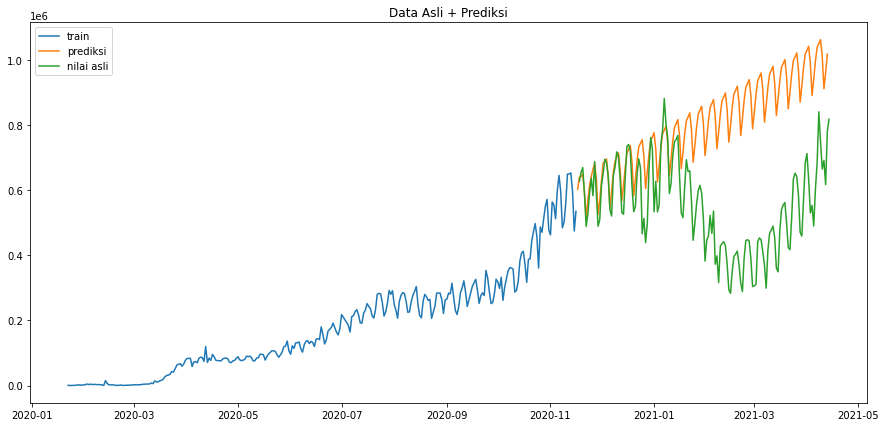

In [ ]:
preds_model_1 = future_preds_df(stepwise_model_case,train['new_cases'],len(test['new_cases']))
plt.figure(figsize=(15,7));
plt.plot(train['new_cases'], label="train");
plt.plot(preds_model_1, label="prediksi")
plt.plot(test['new_cases'], label="nilai asli")
plt.legend(loc="upper left")
plt.title("Data Asli + Prediksi")

## Model 2

In [ ]:
train_model2 = df_analisa.iloc[:369,:]
test_model2 = df_analisa.iloc[370:,:] 

In [ ]:
stepwise_model_case_model2 = pm.auto_arima(train_model2['new_cases'], 
                                    start_p=1, start_q=1,
                                    max_p=5, max_q=5, m=7,
                                    start_P=0, seasonal=True,
                                    d=0, D=1, trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)
print(stepwise_model_case_model2.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=8468.217, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=8706.617, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=8500.607, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=8590.603, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=8732.877, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=8507.780, Time=0.15 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=8463.901, Time=0.49 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=8490.569, Time=0.39 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=8452.908, Time=1.14 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=8461.051, Time=0.77 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=8453.447, Time=1.85 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=8451.493, Time=1.21 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=8452.545, Time=0.83 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=8581.510, Time=0.77 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept

Text(0.5, 1.0, 'Data Asli + Prediksi')

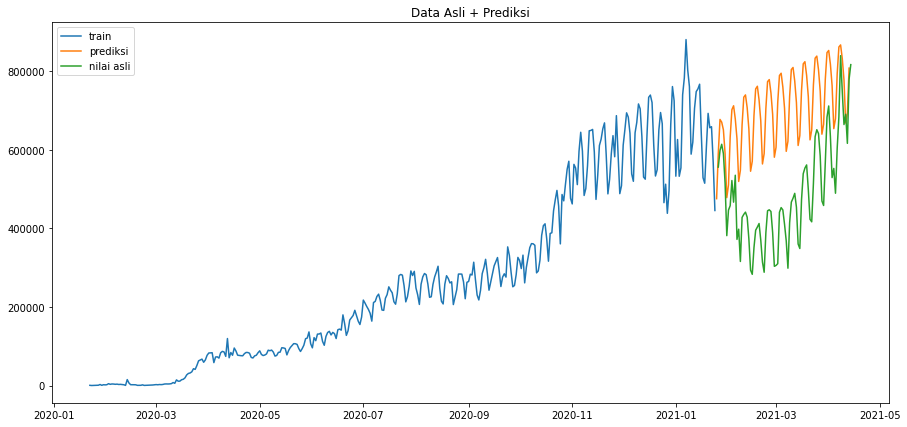

In [ ]:
preds_model_2 = future_preds_df(stepwise_model_case_model2,train_model2['new_cases'],len(test_model2))
plt.figure(figsize=(15,7));
plt.plot(train_model2['new_cases'], label="train");
plt.plot(preds_model_2, label="prediksi")
plt.plot(test_model2['new_cases'], label="nilai asli")
plt.legend(loc="upper left")
plt.title("Data Asli + Prediksi")

## model 3 (exg)

In [ ]:
# Fungsi untuk membuat dataframe hasil prediksi dengan exogenous
def future_preds_df_exg(model,series,num_days):
    pred_first = series.index.max()+timedelta(1)
    pred_last = series.index.max()+timedelta(num_days)
    exg = np.repeat(1, num_days)
    exg = exg.reshape(-1, 1)
    date_range_index = pd.date_range(pred_first,pred_last,freq='D')
    vals = model.predict(n_periods = num_days, X= exg)
    return pd.DataFrame(vals,index = date_range_index)

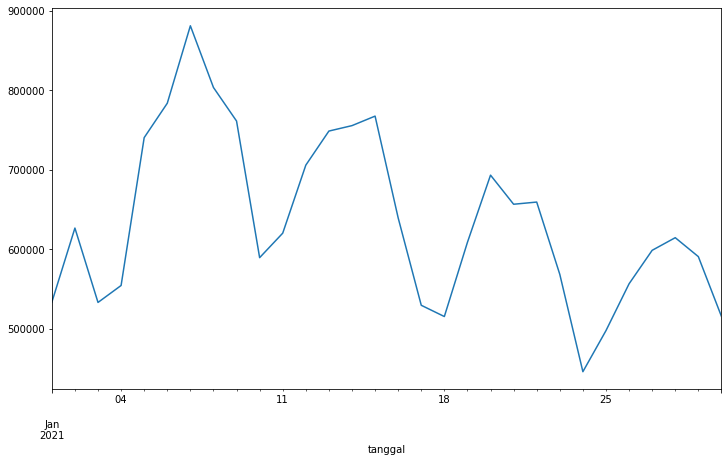

In [ ]:
df_analisa.loc['2021-1-1':'2021-1-30', 'new_cases'].plot()

In [ ]:
df_analisa.loc[:'2021-1-9','unknown_var'] = 0
df_analisa.loc['2021-1-10':,'unknown_var'] = 1
train_model3 = df_analisa.iloc[300:370,:]
test_model3 = df_analisa.iloc[371:,:] 

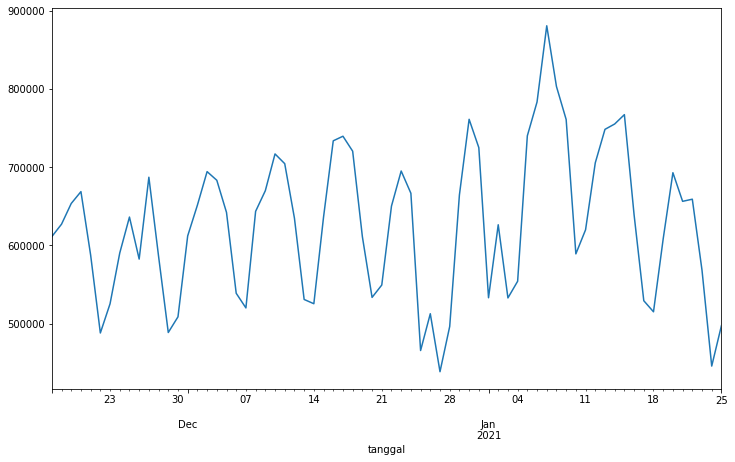

In [ ]:
train_model3['new_cases'].plot()

In [ ]:
stepwise_model_case_model3 = pm.auto_arima(train_model3['new_cases'],
                                    train_model3['unknown_var'].values.reshape(-1, 1), 
                                    start_p=1, start_q=1,
                                    max_p=3, max_q=3, m=7,
                                    start_P=0, seasonal=True,
                                    d=0, D=1, trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)
print(stepwise_model_case_model3.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=1585.238, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1603.750, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1586.208, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1592.030, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1800.869, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=1594.246, Time=0.07 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=1587.006, Time=0.28 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=1587.074, Time=0.34 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=1587.098, Time=0.16 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=1585.195, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=1591.488, Time=0.05 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=1586.901, Time=0.17 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=1586.928, Time=0.19 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : 

Text(0.5, 1.0, 'Data Asli + Prediksi dari Kas Kantor')

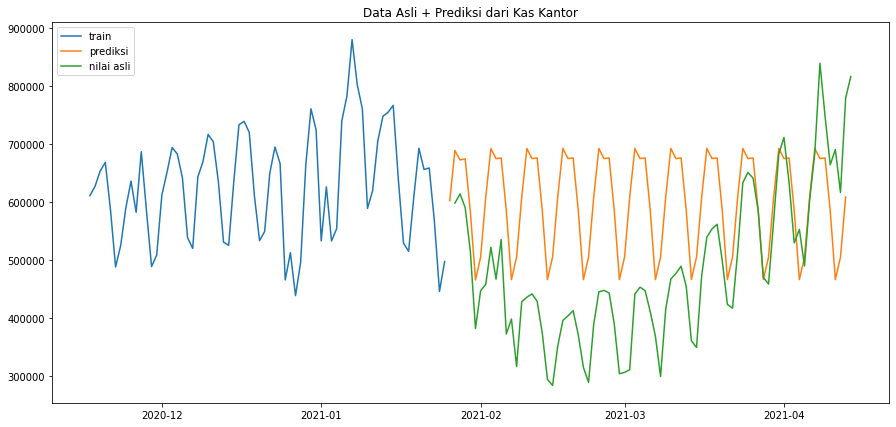

In [ ]:
preds_model_3 = future_preds_df_exg(stepwise_model_case_model3,train_model3['new_cases'],len(test_model3))
plt.figure(figsize=(15,7));
plt.plot(train_model3['new_cases'], label="train");
plt.plot(preds_model_3, label="prediksi")
plt.plot(test_model3['new_cases'], label="nilai asli")
plt.legend(loc="upper left")
plt.title("Data Asli + Prediksi dari Kas Kantor")

## Model 4

In [ ]:
temp = len(df_analisa) -14

In [ ]:
train_model4 = df_analisa.iloc[350:temp,:]
test_model4 = df_analisa.iloc[temp:,:]

In [ ]:
stepwise_model_case_model4 = pm.auto_arima(train_model4['new_cases'], 
                                    start_p=1, start_q=1,
                                    max_p=3, max_q=3, m=7,
                                    start_P=0, seasonal=True,
                                    d=0, D=1, trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)
print(stepwise_model_case_model4.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=1955.904, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=1938.148, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=1943.442, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=1957.624, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=1954.703, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=1938.383, Time=0.27 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=1928.119, Time=0.17 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=1935.572, Time=0.14 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=1929.981, Time=0.37 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=1929.742, Time=0.38 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=1935.360, Time=0.27 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=1956.832, Time=0.15 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=i

Text(0.5, 1.0, 'Data Asli + Prediksi')

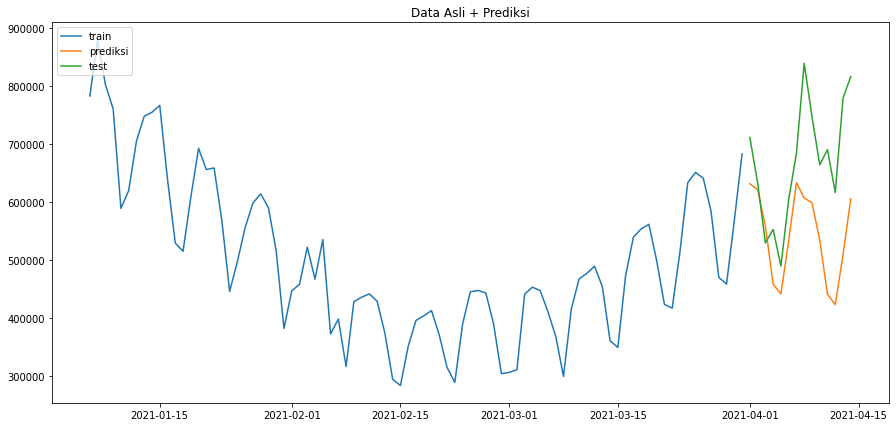

In [ ]:
preds_model_4 = future_preds_df(stepwise_model_case_model4,train_model4['new_cases'],len(test_model4))
plt.figure(figsize=(15,7));
plt.plot(train_model4['new_cases'], label="train");
plt.plot(preds_model_4, label="prediksi")
plt.plot(test_model4['new_cases'], label="test");
plt.legend(loc="upper left")
plt.title("Data Asli + Prediksi")

# modeling kematian

## Model 1

In [ ]:
stepwise_model_death_model1 = pm.auto_arima(train['new_deaths'], 
                                    start_p=1, start_q=1,
                                    max_p=3, max_q=3, m=7,
                                    start_P=0, seasonal=True,
                                    d=0, D=1, trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)
print(stepwise_model_death_model1.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=4769.080, Time=1.33 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=4929.942, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=4876.902, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=4911.325, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=4939.322, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=4869.528, Time=0.60 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=4767.891, Time=1.67 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=4808.655, Time=1.49 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=4782.235, Time=2.87 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=3.60 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=4771.769, Time=2.74 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=4802.401, Time=2.70 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=inf, Time=3.80 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=4902.929, Time=0.98 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=4

Text(0.5, 1.0, 'Data Asli + Prediksi')

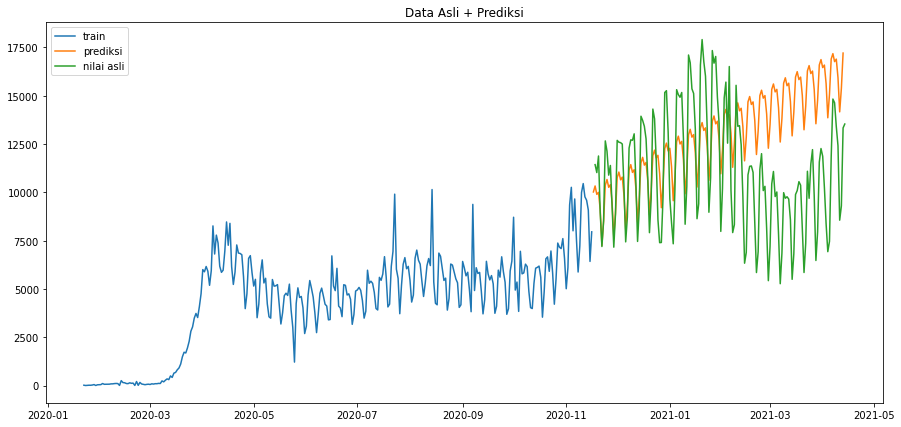

In [ ]:
preds_death_model_1 = future_preds_df(stepwise_model_death_model1,train['new_deaths'],len(test['new_deaths']))
plt.figure(figsize=(15,7));
plt.plot(train['new_deaths'], label="train");
plt.plot(preds_death_model_1, label="prediksi")
plt.plot(test['new_deaths'], label="nilai asli")
plt.legend(loc="upper left")
plt.title("Data Asli + Prediksi")

## Model 2 (mod split)

In [ ]:
len(df_analisa)

449

In [ ]:
train_death_model2 = df_analisa.iloc[:350,:]
test_death_model2 = df_analisa.iloc[351:,:] 

In [ ]:
stepwise_model_death2 = pm.auto_arima(train_death_model2['new_deaths'], 
                                    start_p=1, start_q=1,
                                    max_p=3, max_q=3, m=7,
                                    start_P=0, seasonal=True,
                                    d=0, D=1, trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)
print(stepwise_model_death2.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=5622.779, Time=1.57 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=5771.526, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=5693.158, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=5736.728, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=5784.748, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=5704.828, Time=0.48 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=5629.099, Time=1.74 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=5624.408, Time=3.09 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=5644.123, Time=1.69 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=5622.598, Time=3.50 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=5620.595, Time=4.49 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=5629.355, Time=3.14 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=5720.587, Time=3.53 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=5674.381, Time=2.64 sec
 ARIMA(2,0,1)(2,1,2)[7] intercept

Text(0.5, 1.0, 'Data Asli + Prediksi')

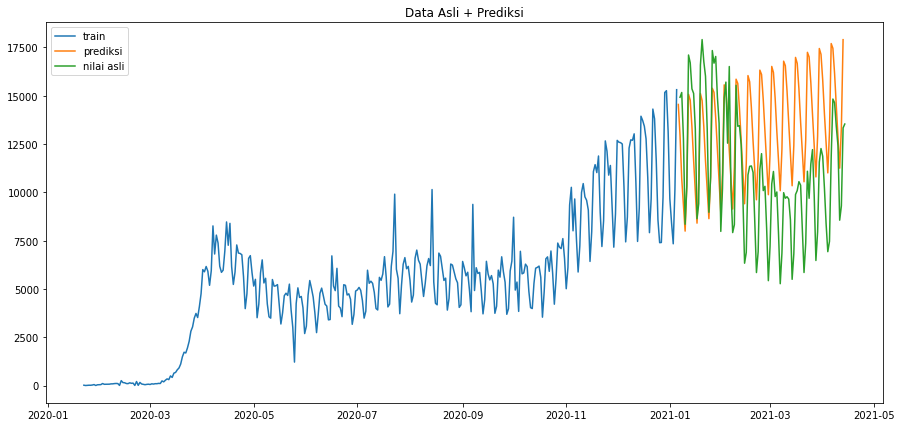

In [ ]:
preds_death_model_2 = future_preds_df(stepwise_model_death2,train_death_model2['new_deaths'],len(test_death_model2))
plt.figure(figsize=(15,7));
plt.plot(train_death_model2['new_deaths'], label="train");
plt.plot(preds_death_model_2, label="prediksi")
plt.plot(test_death_model2['new_deaths'], label="nilai asli")
plt.legend(loc="upper left")
plt.title("Data Asli + Prediksi")

# Evaluasi Kasus

In [ ]:
from sklearn.metrics import mean_squared_error

## Evaluasi Model 1

In [ ]:
mean_squared_error(test['new_cases'], preds_model_1, squared=False)

320993.8370580952

## Evaluasi Model 2

In [ ]:
mean_squared_error(test_model2['new_cases'], preds_model_2, squared=False)

243776.5253384463

## Evaluasi Model 3

In [ ]:
mean_squared_error(test_model3['new_cases'], preds_model_3, squared=False)

173190.18335539318

## Evaluasi Model 4

In [ ]:
mean_squared_error(test_model4['new_cases'], preds_model_4, squared=False)

155214.46277194872

# Evaluasi Kematian

## Evaluasi Model 1

In [ ]:
mean_squared_error(test['new_deaths'], preds_death_model_1, squared=False)

4201.747790378589

## Evaluasi Model 2

In [ ]:
mean_squared_error(test_death_model2['new_deaths'], preds_death_model_2, squared=False)

3962.6985734388318

# Deployment kasus

Text(0.5, 1.0, 'Data Asli + Prediksi')

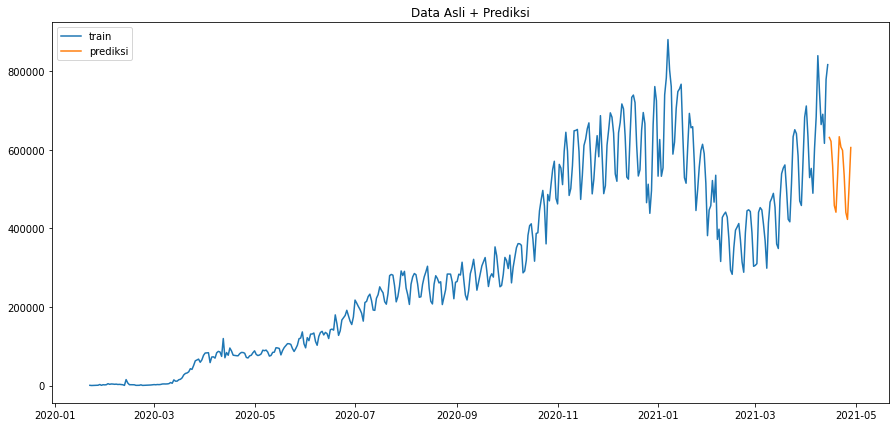

In [ ]:
preds_case_deploy = future_preds_df(stepwise_model_case_model4,df_analisa['new_cases'],14)
plt.figure(figsize=(15,7));
plt.plot(df_analisa['new_cases'], label="train");
plt.plot(preds_case_deploy, label="prediksi")
plt.legend(loc="upper left")
plt.title("Data Asli + Prediksi")

# Deployment Kematian

Text(0.5, 1.0, 'Data Asli + Prediksi')

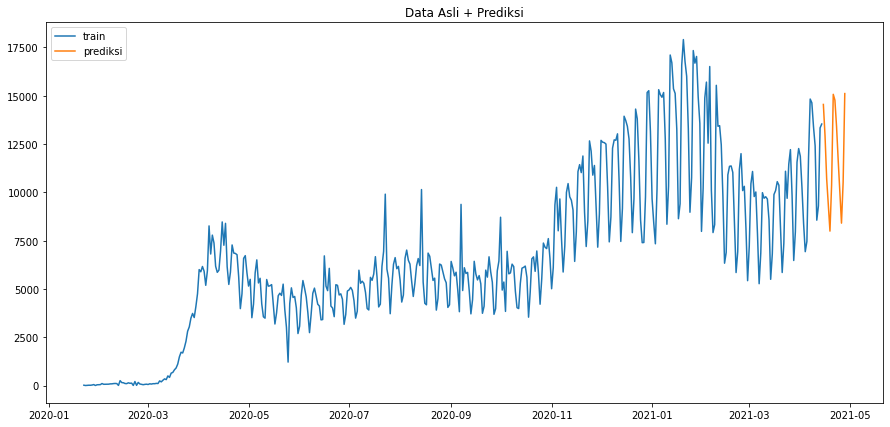

In [ ]:
preds_death_deploy = future_preds_df(stepwise_model_death2,df_analisa['new_deaths'],14)
plt.figure(figsize=(15,7));
plt.plot(df_analisa['new_deaths'], label="train")
plt.plot(preds_death_deploy, label="prediksi")
plt.legend(loc="upper left")
plt.title("Data Asli + Prediksi")

# Upload

In [ ]:
df_header_upload.to_json('/content/gdrive/My Drive/Web Covid-19/datasets/dataHeader.json', orient='records')

In [ ]:
df_prediction = df_analisa.copy()
preds_case_deploy= preds_case_deploy.rename(columns={0 :'case_prediction'})
preds_death_deploy = preds_death_deploy.rename(columns={0 :'death_prediction'})

df_prediction = pd.concat([df_prediction, preds_case_deploy, preds_death_deploy], axis=1)
df_prediction_reset_index = df_prediction.reset_index()

In [ ]:
from gspread_dataframe import set_with_dataframe

sheet = gc.open('df_prediction').sheet1
sheet_reset_index = gc.open('df_prediction_reset_index').sheet1
sheet_data_core = gc.open('data_core').sheet1
sheet_data_map = gc.open('data_map').sheet1
sheet_data_pie = gc.open('data_pie').sheet1
sheet_data_world_graph = gc.open('data_world_graph').sheet1
sheet_indonesia_graph = gc.open('data_indonesia_graph').sheet1
sheet_df_regional = gc.open('data_regional').sheet1

set_with_dataframe(sheet, df_prediction) 
set_with_dataframe(sheet_reset_index, df_prediction_reset_index)
set_with_dataframe(sheet_data_core, df) 
set_with_dataframe(sheet_data_map, df_map) 
set_with_dataframe(sheet_data_pie, df_pie) 
set_with_dataframe(sheet_data_world_graph, df_worldGraph) 
set_with_dataframe(sheet_indonesia_graph, df_idGraph)
set_with_dataframe(sheet_df_regional, df_regional)
# include_index=False, include_column_header=True, resize=False